In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import files
files.upload();

Saving training_data.csv to training_data (1).csv


In [ ]:
train_df = pd.read_csv('training_data.csv',
                       sep='\t',
                       header=None,
                       names=['label', 'text'],
                       encoding='utf-8')

In [ ]:
print(f"Training data shape: {train_df.shape}")

Training data shape: (34152, 3)


In [ ]:
train_df.head(10)

,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...
5,0,racist alabama cops brutalize black boy while ...
6,0,fresh off the golf course
7,0,trump said some insanely racist stuff inside t...
8,0,former cia director slams trump over un bullying
9,0,brand-new pro-trump ad features so much a** ki...


In [ ]:
print("Label distribution in training data:")
print(train_df['label'].value_counts())
print(f"\nClass 0: Real News")
print(f"Class 1: Fake News")

Label distribution in training data:
label
0    17572
1    16580
Name: count, dtype: int64

Class 0: Real News
Class 1: Fake News


In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

STOP_WORDS = set(ENGLISH_STOP_WORDS)

In [ ]:
print(f"Number of stop words: {len(STOP_WORDS)}")

Number of stop words: 318


In [ ]:
def preprocess_text(text):
    """
    Preprocess text by:
    - Converting to lowercase
    - Removing special characters and numbers
    - Tokenizing
    - Removing stop words
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Remove special characters, URLs, and numbers
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Simple tokenization
    tokens = text.split()

    # Remove stop words and short words
    tokens = [token for token in tokens
              if token not in STOP_WORDS and len(token) > 2]

    return ' '.join(tokens)

In [ ]:
# Apply preprocessing to training data
print("Preprocessing training data...")
train_df['processed_text'] = train_df['text'].apply(preprocess_text)



Preprocessing training data...


In [ ]:
train_df.text

,text
0,donald trump sends out embarrassing new year‚s...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes an internet joke ...
3,trump is so obsessed he even has obama‚s name ...
4,pope francis just called out donald trump duri...
...,...
34147,tears in rain as thais gather for late king's ...
34148,pyongyang university needs non-u.s. teachers a...
34149,philippine president duterte to visit japan ah...
34150,japan's abe may have won election\tbut many do...


In [ ]:
train_df.processed_text

,processed_text
0,donald trump sends embarrassing new years eve ...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke internet joke threatening...
3,trump obsessed obamas coded website images
4,pope francis just called donald trump christma...
...,...
34147,tears rain thais gather late kings funeral
34148,pyongyang university needs nonus teachers trav...
34149,philippine president duterte visit japan ahead...
34150,japans abe won election dont want


In [ ]:
print("Example of text preprocessing:")
print("="*60)
for i in range(3):
    print(f"\nOriginal {i+1}: {train_df['text'].iloc[i][:100]}...")
    print(f"Processed {i+1}: {train_df['processed_text'].iloc[i][:100]}...")
    print("-"*60)

Example of text preprocessing:

Original 1: donald trump sends out embarrassing new year‚s eve message; this is disturbing...
Processed 1: donald trump sends embarrassing new years eve message disturbing...
------------------------------------------------------------

Original 2: drunk bragging trump staffer started russian collusion investigation...
Processed 2: drunk bragging trump staffer started russian collusion investigation...
------------------------------------------------------------

Original 3: sheriff david clarke becomes an internet joke for threatening to poke people ‚in the eye‚...
Processed 3: sheriff david clarke internet joke threatening poke people eye...
------------------------------------------------------------


In [ ]:
X=train_df["processed_text"]
y=train_df["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"\nTraining label distribution:")
print(y_train.value_counts())
print(f"\nValidation label distribution:")
print(y_val.value_counts())

Training set size: 27321
Validation set size: 6831

Training label distribution:
label
0    14057
1    13264
Name: count, dtype: int64

Validation label distribution:
label
0    3515
1    3316
Name: count, dtype: int64


In [ ]:
# Define different vectorizers to experiment with
vectorizers = {

    'TF-IDF (1,2-gram)': TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=15000,
        min_df=2,
        max_df=0.90
    ),
    'TF-IDF (1,2,3-gram)': TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=20000,
        min_df=2,
        max_df=0.90
    ),
    'Count Vectorizer': CountVectorizer(
        max_features=10000,
        min_df=2,
        max_df=0.95
    )
}

print("Vectorizers defined:")
for name in vectorizers:
    print(f"  - {name}")

Vectorizers defined:
  - TF-IDF (1,2-gram)
  - TF-IDF (1,2,3-gram)
  - Count Vectorizer


In [ ]:
print("Testing different vectorizers with Logistic Regression:")
print("="*60)

vectorizer_results = {}
for name, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_val_vec)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    vectorizer_results[name] = {'accuracy': accuracy, 'f1': f1}

    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print()

Testing different vectorizers with Logistic Regression:
TF-IDF (1,2-gram):
  Accuracy: 0.9310
  F1-Score: 0.9299

TF-IDF (1,2,3-gram):
  Accuracy: 0.9318
  F1-Score: 0.9306

Count Vectorizer:
  Accuracy: 0.9322
  F1-Score: 0.9312



In [ ]:
from xgboost import XGBClassifier

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Linear SVM': LinearSVC(random_state=42, max_iter=2000),
    'Multinomial NB': MultinomialNB(),
    'XGBoost':XGBClassifier(
        n_estimators=200,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )

}

print("Models to compare:")
for name in models:
    print(f"  - {name}")

Models to compare:
  - Logistic Regression
  - Random Forest
  - Linear SVM
  - Multinomial NB
  - XGBoost


In [ ]:
best_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=15000,
    min_df=2,
    max_df=0.90
)

X_train_tfidf = best_vectorizer.fit_transform(X_train)
X_val_tfidf = best_vectorizer.transform(X_val)

print(f"Vectorizer vocabulary size: {len(best_vectorizer.vocabulary_)}")
print(f"Training matrix shape: {X_train_tfidf.shape}")
print(f"Validation matrix shape: {X_val_tfidf.shape}")

Vectorizer vocabulary size: 15000
Training matrix shape: (27321, 15000)
Validation matrix shape: (6831, 15000)


In [ ]:
results = {}
trained_models = {}

print("Training and evaluating models:")
print("="*70)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model

    # Predict on validation set
    y_pred = model.predict(X_val_tfidf)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    print(f"{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

Training and evaluating models:

Training Logistic Regression...
Logistic Regression:
  Accuracy:  0.9310
  Precision: 0.9185
  Recall:    0.9415
  F1-Score:  0.9299

Training Random Forest...
Random Forest:
  Accuracy:  0.9147
  Precision: 0.9061
  Recall:    0.9195
  F1-Score:  0.9127

Training Linear SVM...
Linear SVM:
  Accuracy:  0.9368
  Precision: 0.9297
  Recall:    0.9409
  F1-Score:  0.9353

Training Multinomial NB...
Multinomial NB:
  Accuracy:  0.9332
  Precision: 0.9400
  Recall:    0.9213
  F1-Score:  0.9306

Training XGBoost...
XGBoost:
  Accuracy:  0.8937
  Precision: 0.8494
  Recall:    0.9493
  F1-Score:  0.8966


In [ ]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('f1', ascending=False)
print("Model Comparison Results:")
results_df

Model Comparison Results:


,accuracy,precision,recall,f1
Linear SVM,0.936759,0.929678,0.940893,0.935252
Multinomial NB,0.933245,0.940000,0.921291,0.930551
Logistic Regression,0.931050,0.918505,0.941496,0.929859
Random Forest,0.914654,0.906092,0.919481,0.912738
XGBoost,0.893720,0.849433,0.949337,0.896611


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
print("Visualization libraries imported!")

Visualization libraries imported!


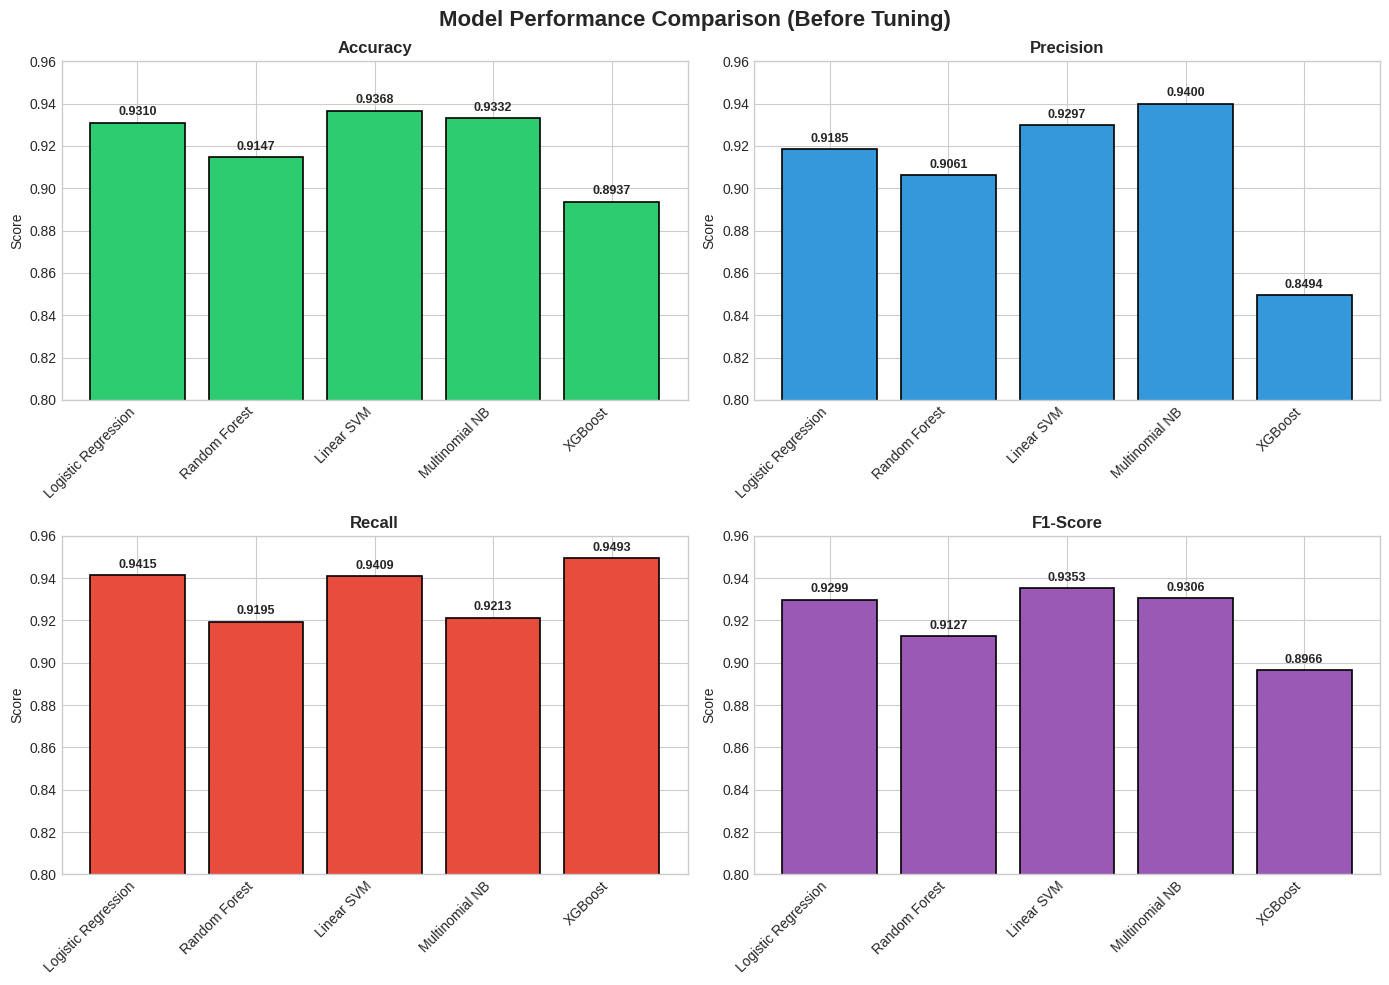


Bar graph saved as 'model_comparison_before_tuning.png'


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison (Before Tuning)', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

model_names = list(results.keys())

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx // 2, idx % 2]
    values = [results[model][metric] for model in model_names]

    bars = ax.bar(model_names, values, color=color, edgecolor='black', linewidth=1.2)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim(0.80, 0.96)

    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Rotate x-axis labels for better readability
    ax.set_xticklabels(model_names, rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison_before_tuning.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nBar graph saved as 'model_comparison_before_tuning.png'")

In [ ]:
# Tune Logistic Regression
print("Tuning Logistic Regression...")
print("="*50)

lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    lr_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
lr_grid.fit(X_train_tfidf, y_train)

print(f"Best parameters: {lr_grid.best_params_}")
print(f"Best CV F1-Score: {lr_grid.best_score_:.4f}")

Tuning Logistic Regression...
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1-Score: 0.9320


In [ ]:
# Tune Linear SVM
print("Tuning Linear SVM...")
print("="*50)

svm_params = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge']
}

svm_grid = GridSearchCV(
    LinearSVC(random_state=42, max_iter=4000),
    svm_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
svm_grid.fit(X_train_tfidf, y_train)

print(f"Best parameters: {svm_grid.best_params_}")
print(f"Best CV F1-Score: {svm_grid.best_score_:.4f}")

Tuning Linear SVM...
Best parameters: {'C': 1, 'loss': 'squared_hinge'}
Best CV F1-Score: 0.9310


In [ ]:
# Tune Multinomial NB
print("Tuning Multinomial NB...")
print("="*50)

nb_params = {
    'alpha': [0.01, 0.1, 0.5, 1.0]
}

nb_grid = GridSearchCV(
    MultinomialNB(),
    nb_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
nb_grid.fit(X_train_tfidf, y_train)

print(f"Best parameters: {nb_grid.best_params_}")
print(f"Best CV F1-Score: {nb_grid.best_score_:.4f}")

Tuning Multinomial NB...
Best parameters: {'alpha': 0.5}
Best CV F1-Score: 0.9272


In [ ]:
# Tune Multinomial NB
print("Tuning Multinomial NB...")
print("="*50)

nb_params = {
    'alpha': [0.01, 0.1, 0.5, 1.0]
}

nb_grid = GridSearchCV(
    MultinomialNB(),
    nb_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
nb_grid.fit(X_train_tfidf, y_train)

print(f"Best parameters: {nb_grid.best_params_}")
print(f"Best CV F1-Score: {nb_grid.best_score_:.4f}")

Tuning Multinomial NB...
Best parameters: {'alpha': 0.5}
Best CV F1-Score: 0.9272


In [ ]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [ ]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1
    ),
    xgb_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)


In [ ]:
xgb_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 6],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='f1')

In [ ]:
print("Best parameters:", xgb_grid.best_params_)
print("Best CV F1-score:", xgb_grid.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
Best CV F1-score: 0.8682573141298745


In [ ]:
# Evaluate tuned models on validation set
tuned_models = {
    'Tuned Logistic Regression': lr_grid.best_estimator_,
    'Tuned Linear SVM': svm_grid.best_estimator_,
    'Tuned Multinomial NB': nb_grid.best_estimator_
}

tuned_results = {}

print("Tuned model performance on validation set:")
print("="*70)

for name, model in tuned_models.items():
    y_pred = model.predict(X_val_tfidf)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    tuned_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model
    }

    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

Tuned model performance on validation set:

Tuned Logistic Regression:
  Accuracy:  0.9391
  Precision: 0.9323
  Recall:    0.9430
  F1-Score:  0.9376

Tuned Linear SVM:
  Accuracy:  0.9368
  Precision: 0.9297
  Recall:    0.9409
  F1-Score:  0.9353

Tuned Multinomial NB:
  Accuracy:  0.9327
  Precision: 0.9388
  Recall:    0.9213
  F1-Score:  0.9300


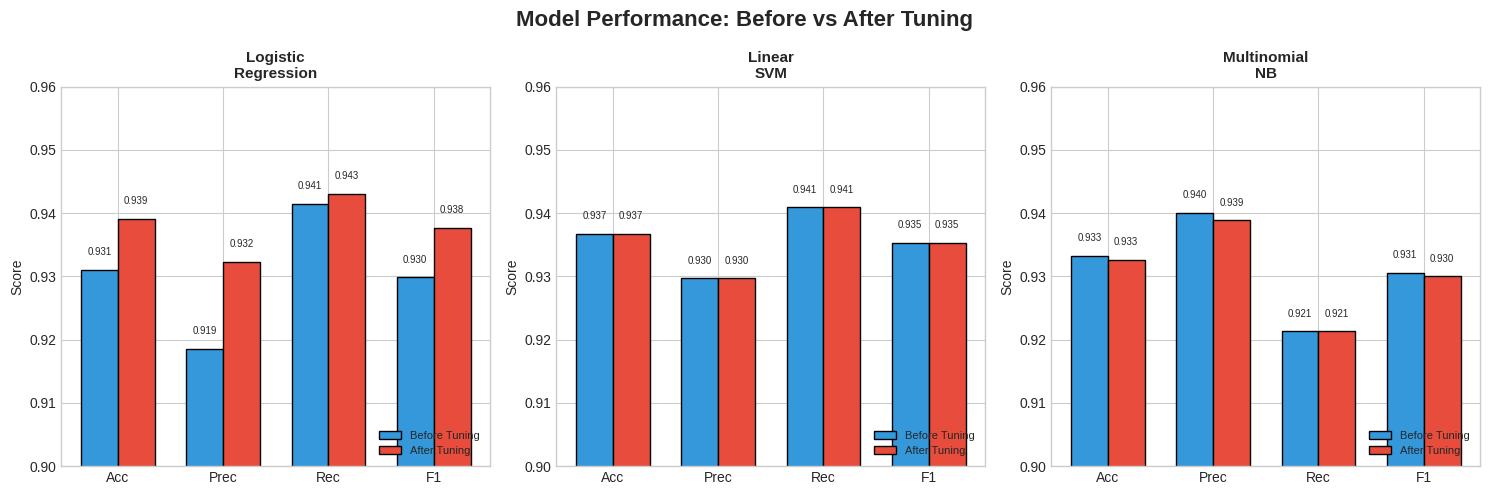


Comparison saved as 'before_after_tuning_comparison.png'


In [ ]:
# Create comparison bar graph: Before vs After Tuning
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Performance: Before vs After Tuning', fontsize=16, fontweight='bold')

# Models that were tuned
comparison_models = [
    ('Logistic Regression', 'Tuned Logistic Regression'),
    ('Linear SVM', 'Tuned Linear SVM'),
    ('Multinomial NB', 'Tuned Multinomial NB')
]

for idx, (before_name, after_name) in enumerate(comparison_models):
    ax = axes[idx]

    # Get metrics
    metrics_list = ['accuracy', 'precision', 'recall', 'f1']
    before_values = [results[before_name][m] for m in metrics_list]
    after_values = [tuned_results[after_name][m] for m in metrics_list]

    x = np.arange(len(metrics_list))
    width = 0.35

    bars1 = ax.bar(x - width/2, before_values, width, label='Before Tuning',
                   color='#3498db', edgecolor='black')
    bars2 = ax.bar(x + width/2, after_values, width, label='After Tuning',
                   color='#e74c3c', edgecolor='black')

    ax.set_title(before_name.replace(' ', '\n'), fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Acc', 'Prec', 'Rec', 'F1'])
    ax.set_ylim(0.90, 0.96)
    ax.legend(loc='lower right', fontsize=8)
    ax.set_ylabel('Score')

    # Add value labels
    for bar in bars1:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=7)
    for bar in bars2:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig('before_after_tuning_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nComparison saved as 'before_after_tuning_comparison.png'")

In [ ]:
all_results = {**results, **tuned_results}

# Find best model based on F1 score
best_model_name = max(all_results, key=lambda x: all_results[x]['f1'])
best_f1 = all_results[best_model_name]['f1']

print("\nAll Model Rankings (by F1-Score):")
print("="*50)
for name, result in sorted(all_results.items(), key=lambda x: x[1]['f1'], reverse=True):
    print(f"{name}: {result['f1']:.4f}")

print(f"\n*** Best Model: {best_model_name} ***")
print(f"*** F1-Score: {best_f1:.4f} ***")


All Model Rankings (by F1-Score):
Tuned Logistic Regression: 0.9376
Linear SVM: 0.9353
Tuned Linear SVM: 0.9353
Multinomial NB: 0.9306
Tuned Multinomial NB: 0.9300
Logistic Regression: 0.9299
Random Forest: 0.9127
XGBoost: 0.8966

*** Best Model: Tuned Logistic Regression ***
*** F1-Score: 0.9376 ***


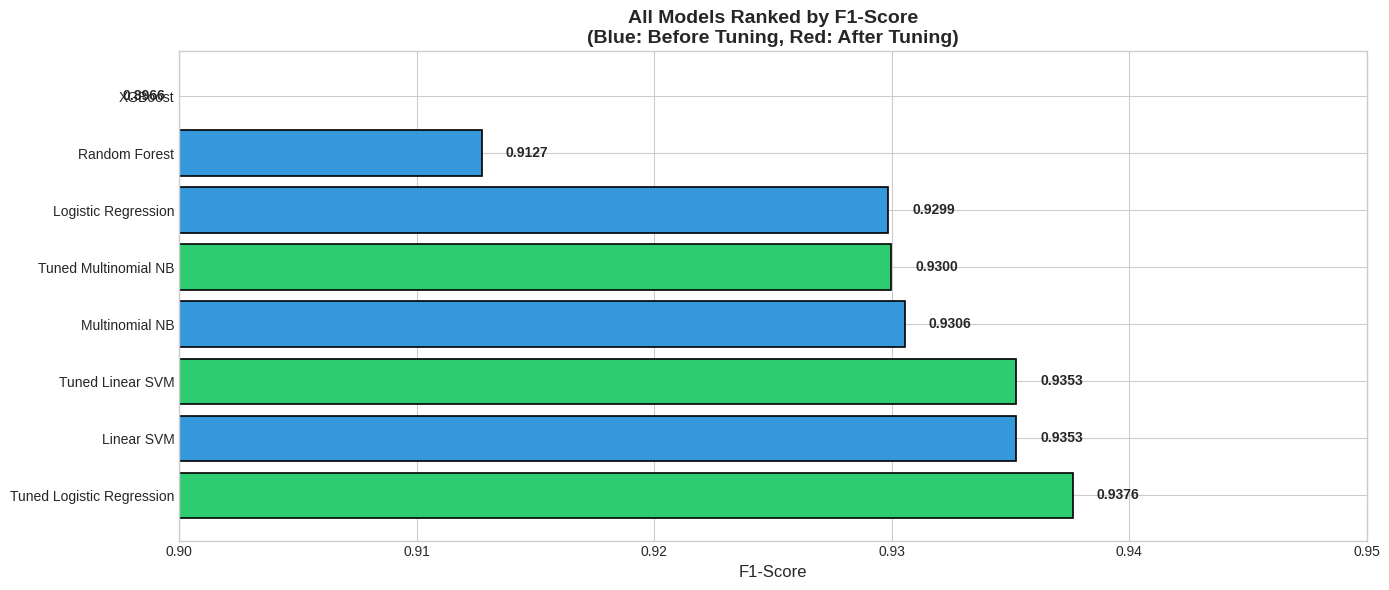


Ranking chart saved as 'all_models_ranking.png'


In [ ]:
# Final comprehensive bar chart comparing all models
fig, ax = plt.subplots(figsize=(14, 6))

# Prepare data
all_model_names = list(all_results.keys())
f1_scores = [all_results[name]['f1'] for name in all_model_names]

# Sort by F1 score
sorted_pairs = sorted(zip(all_model_names, f1_scores), key=lambda x: x[1], reverse=True)
sorted_names, sorted_f1 = zip(*sorted_pairs)

# Create colors (tuned models in different color)
colors = ['#2ecc71' if 'Tuned' in name else '#3498db' for name in sorted_names]

bars = ax.barh(sorted_names, sorted_f1, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels
for bar, val in zip(bars, sorted_f1):
    ax.text(val + 0.001, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('F1-Score', fontsize=12)
ax.set_title('All Models Ranked by F1-Score\n(Blue: Before Tuning, Red: After Tuning)',
             fontsize=14, fontweight='bold')
ax.set_xlim(0.85, 0.95)

plt.tight_layout()
plt.savefig('all_models_ranking.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nRanking chart saved as 'all_models_ranking.png'")

In [ ]:
# Retrain on full training data
print("Retraining best model on full training set...")
print("="*50)

# Create new vectorizer for full training data
full_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=15000,
    min_df=2,
    max_df=0.95
)

X_full_train = full_vectorizer.fit_transform(train_df['processed_text'])

# Create final model with best parameters
if 'Logistic Regression' in best_model_name:
    final_model = LogisticRegression(**lr_grid.best_params_, max_iter=1000, random_state=42)
elif 'SVM' in best_model_name:
    final_model = LinearSVC(**svm_grid.best_params_, random_state=42, max_iter=2000)
elif 'NB' in best_model_name:
    final_model = MultinomialNB(**nb_grid.best_params_)
else:
    final_model = best_model

final_model.fit(X_full_train, train_df['label'])
print(f"Model retrained on {len(train_df)} samples")
print(f"Vocabulary size: {len(full_vectorizer.vocabulary_)}")

Retraining best model on full training set...
Model retrained on 34152 samples
Vocabulary size: 15000


In [ ]:
from google.colab import files
files.upload();

Saving testing_data.csv to testing_data.csv


In [ ]:
test_df = pd.read_csv('testing_data.csv',
                      sep='\t',
                      header=None,
                      names=['label', 'text'],
                      encoding='utf-8')

In [ ]:
print("Preprocessing testing data...")
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

Preprocessing testing data...


In [ ]:
# Transform test data and make predictions
print("Making predictions on test set...")
print("="*50)

X_test = full_vectorizer.transform(test_df['processed_text'])
predictions = final_model.predict(X_test)

print(f"Predictions made for {len(predictions)} samples")
print(f"\nPrediction distribution:")
print(pd.Series(predictions).value_counts())
print(f"\nClass 0 (Real News): {sum(predictions == 0)}")
print(f"Class 1 (Fake News): {sum(predictions == 1)}")

Making predictions on test set...
Predictions made for 9984 samples

Prediction distribution:
1    5228
0    4756
Name: count, dtype: int64

Class 0 (Real News): 4756
Class 1 (Fake News): 5228


In [ ]:
# Create output dataframe and save
output_df = test_df[['label', 'text']].copy()
output_df['label'] = predictions

# Save predictions
output_path = 'testing_data_predictions.csv'
output_df.to_csv(output_path, sep='\t', index=False, header=False)
print(f"Predictions saved to: {output_path}")

Predictions saved to: testing_data_predictions.csv


In [ ]:
print(f"Training data shape: {test_df.shape}")

Training data shape: (9984, 3)


In [ ]:
# Display sample predictions
print("Sample predictions:")
print("="*70)
sample_output = output_df.head(10)
for idx, row in sample_output.iterrows():
    label = "Real" if row['label'] == 0 else "Fake"
    print(f"[{label}] {row['text'][:60]}...")

Sample predictions:
[Real] copycat muslim terrorist arrested with assault weapons...
[Real] wow! chicago protester caught on camera admits violent activ...
[Real] germany's fdp look to fill schaeuble's big shoes...
[Real] mi school sends welcome back packet warning kids against wea...
[Fake] u.n. seeks 'massive' aid boost amid rohingya 'emergency with...
[Real] did oprah just leave ‚nasty‚ hillary wishing she wouldn‚t ha...
[Fake] france's macron says his job not 'cool' cites talks with tur...
[Real] flashback: chilling ‚60 minutes‚ interview with george soros...
[Fake] spanish foreign ministry says to expel north korean ambassad...
[Fake] trump says cuba 'did some bad things' aimed at u.s. diplomat...


In [ ]:
print("="*60)
print("PROJECT SUMMARY")
print("="*60)

print("\n1. Data Overview:")
print(f"   - Training samples: {len(train_df)}")
print(f"   - Test samples: {len(test_df)}")

print("\n2. Preprocessing:")
print("   - Lowercasing")
print("   - URL and special character removal")
print("   - Tokenization")
print("   - Stop word removal")

print("\n3. Best Vectorization:")
print("   - TF-IDF with (1,2)-grams")
print("   - Max features: 15,000")
print("   - min_df: 2, max_df: 0.95")

print("\n4. Models Tested:")
print("   - Logistic Regression")
print("   - Random Forest")
print("   - Linear SVM")
print("   - Multinomial Naive Bayes")

print(f"\n5. Best Model: {best_model_name}")
print(f"   - F1-Score: {best_f1:.4f}")
print(f"   - Accuracy: {all_results[best_model_name]['accuracy']:.4f}")

print("\n6. Test Predictions:")
print(f"   - Total: {len(predictions)}")
print(f"   - Real News (0): {sum(predictions == 0)}")
print(f"   - Fake News (1): {sum(predictions == 1)}")

print("\n" + "="*60)
print("PROJECT COMPLETE!")
print("="*60)

PROJECT SUMMARY

1. Data Overview:
   - Training samples: 34152
   - Test samples: 9984

2. Preprocessing:
   - Lowercasing
   - URL and special character removal
   - Tokenization
   - Stop word removal

3. Best Vectorization:
   - TF-IDF with (1,2)-grams
   - Max features: 15,000
   - min_df: 2, max_df: 0.95

4. Models Tested:
   - Logistic Regression
   - Random Forest
   - Linear SVM
   - Multinomial Naive Bayes

5. Best Model: Tuned Logistic Regression
   - F1-Score: 0.9376
   - Accuracy: 0.9391

6. Test Predictions:
   - Total: 9984
   - Real News (0): 4756
   - Fake News (1): 5228

PROJECT COMPLETE!
